# Value Estimation -- quadrature vs uniform

In [195]:
import math
from importlib import reload

import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [150]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

## Load a goodish policy, generate data to process

Recall, we want:

1. The policy to stay up for ~10k steps, while we interact for 20k steps.
2. To generate trajectories from 100 different initial states.

We just need to store the fine grained rewards for each of these trajectories, all processing will happen on this after. 

In [208]:
# GENERATE_NEW_DATA = False
GENERATE_NEW_DATA = True

# SAVE_TRAJECTORIES = False
SAVE_TRAJECTORIES = True


# discrete_reward = False
discrete_reward = True

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"

load_data_from = f"many_good_trajs_{reward_type}.pkl"


In [209]:
if GENERATE_NEW_DATA:
    seed = 13
    STEPS_MAX = 20_000
    STEPS_BREAK = 9_000
    NUM_TRAJS = 100

    from adaptive_time import mc2
    import adaptive_time.utils
    import gymnasium as gym
    import random

    env = gym.make('CartPole-OURS-v2', discrete_reward=discrete_reward)
    _NUM_ACTIONS = 2

    phi = run_lib.make_features()

    weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
    # weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

    # implement epsilon-greedy action sampling. 
    def policy(state, num_step, weights, epsilon):
        """Returns the action to take, and maybe the prob of all actions"""
        if num_step >= STEPS_BREAK:
            # Going to try to make failing and staying down likely.
            dir_ = None   # -1 for left, 1 for right
            outcome = random.random()
            if outcome < 0.8:
                # Strategy: if angle is close to 0, act to speed the pole up,
                #   if it is farther, act to slow it down.
                if abs(state[2]) < 0.1:
                    dir_ = math.copysign(1, state[3])
                else:
                    dir_ = math.copysign(1, -state[3])
            else:
                # Aim towards the center, but only if not too fast.
                dir_ = math.copysign(1, -(state[0]+state[1]*2))
            return int((dir_+1)/2)
            # outcome = random.random()
            # if outcome < 0.1:
            #     return 0
            # else:
            # # if outcome < 0.99:
            #     if state[1] < 0:
            #         return 1
            #     else:
            #         return 0
        elif random.random() < epsilon:
            action = env.action_space.sample()
            return action

        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return adaptive_time.utils.argmax(qs)

    run_lib.reset_randomness(seed, env)

    def _random_start_state(num):
        rand = np.random.standard_normal((num, 4))
        # rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        return rand

    start_states = _random_start_state(NUM_TRAJS)
    print("shape", start_states.shape)
    print("max", np.max(start_states, axis=0))

    total_rewards = []
    reward_sequences = []
    traj_lengths = []
    angles = []
    xs = []
    d_angles = []
    actions = []
    dxs = []
    for idx in tqdm(range(NUM_TRAJS)):
        start_state = tuple(start_states[idx])
        # Tuple[float, float, float, float]
        trajectory, early_term = value_est.generate_trajectory(
                env, start_state=start_state,
                policy=lambda st, sn: policy(st, sn, weights_good_policy, 0.0),
                termination_prob=0.0, max_steps=STEPS_MAX)

        traj_lengths.append(len(trajectory))
        rewards = [r for _, _, r, _ in trajectory]
        actions.append([a for _, a, _, _ in trajectory])
        xs.append([s[0] for s, _, _, _ in trajectory])
        angles.append([s[2] for s, _, _, _ in trajectory])
        d_angles.append([s[3] for s, _, _, _ in trajectory])
        dxs.append([s[1] for s, _, _, _ in trajectory])
        reward_sequences.append(rewards)
        total_rewards.append(sum(rewards))

    total_rewards = np.array(total_rewards)
    reward_sequences = np.array(reward_sequences)
    traj_lengths = np.array(traj_lengths)
    angles = np.array(angles)
    xs = np.array(xs)
    d_angles = np.array(d_angles)
    actions = np.array(actions)
    dxs = np.array(dxs)

    if SAVE_TRAJECTORIES:
        all_traj_data = (
            total_rewards, reward_sequences, traj_lengths,
            angles, xs, d_angles, actions, dxs
        )
        with open(load_data_from, "wb") as f:
            pickle.dump(all_traj_data, f)
        print("Saved data to", load_data_from)

else:
    with open(load_data_from, "rb") as f:
        all_traj_data = pickle.load(f)
    (
        total_rewards, reward_sequences, traj_lengths,
        angles, xs, d_angles, actions, dxs
    ) = all_traj_data

    print("Loaded data from", load_data_from)


print("total_rewards for each traj:", total_rewards)
print("all rewards shape:", reward_sequences.shape)
num_trajs = len(total_rewards)

shape (100, 4)
max [0.01849613 0.03401106 0.01296042 0.00477349]


  0%|          | 0/100 [00:00<?, ?it/s]

Saved data to many_good_trajs_discrete.pkl
total_rewards for each traj: [9057. 9143. 9123. 9142. 9094. 9112. 9133. 9102. 9150. 9113. 9123. 9148.
 9052. 9182. 9177. 9161. 9074. 9048. 9160. 9121. 9139. 9217. 9140. 9102.
 9097. 9095. 9242. 9157. 9082. 9163. 9048. 9110. 9114. 9118. 9106. 9072.
 9100. 9176. 9094. 9067. 9152. 9080. 9120. 9104. 9086. 9073. 9133. 9181.
 9175. 9069. 9075. 9093. 9109. 9070. 9215. 9074. 9094. 9079. 9073. 9075.
 9196. 9220. 9181. 9073. 9153. 9128. 9081. 9187. 9057. 9110. 9072. 9082.
 9080. 9085. 9394. 9061. 9120. 9107. 9055. 9096. 9096. 9299. 9100. 9098.
 9044. 9178. 9064. 9052. 9094. 9149. 9074. 9129. 9221. 9113. 9118. 9125.
 9167. 9139. 9185. 9136.]
all rewards shape: (100, 20001)


In [210]:
12 * 2 * math.pi / 360

0.20943951023931953

### Analyze trajectories

(array([23., 31., 20., 16.,  5.,  3.,  0.,  1.,  0.,  1.]),
 array([9044., 9079., 9114., 9149., 9184., 9219., 9254., 9289., 9324.,
        9359., 9394.]),
 <BarContainer object of 10 artists>)

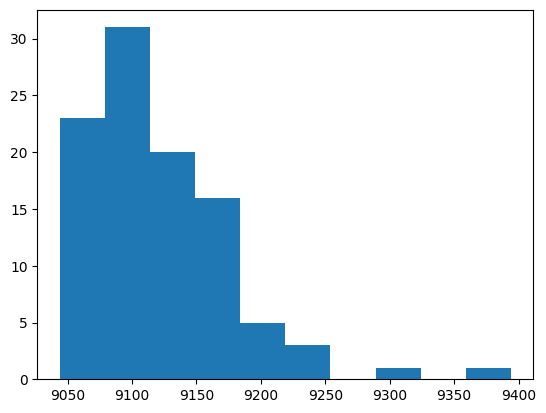

In [211]:
plt.hist(total_rewards)

9299.0


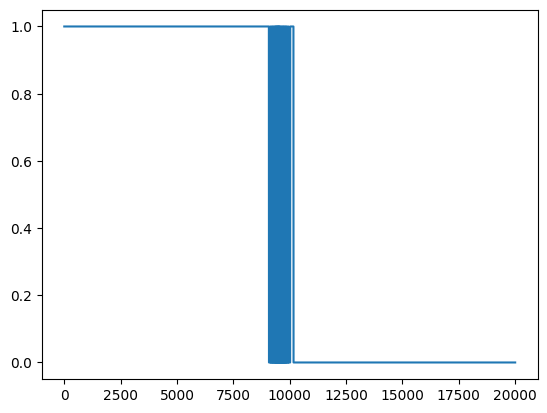

In [212]:
traj_idx = 81
print(total_rewards[traj_idx])
plt.plot(reward_sequences[traj_idx])

Text(0.5, 1.0, 'Velocity')

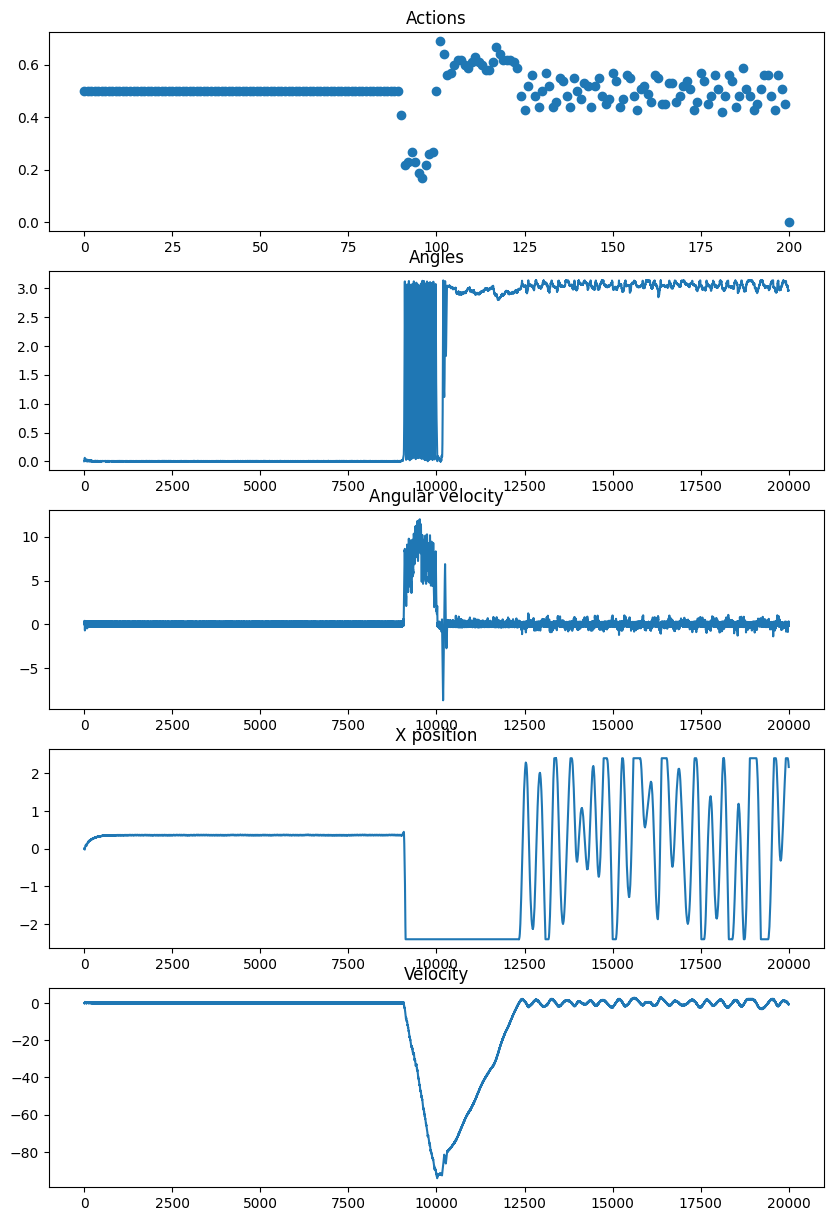

In [213]:
fig, ax = plt.subplots(5, 1, figsize=(10, 15))

# Actions -- bin them:
binsize = 100
binned_actions = []
for i in range(0, len(actions[traj_idx]), binsize):
    binned_actions.append(np.mean(actions[traj_idx][i:i+binsize]))
ax[0].plot(binned_actions, linestyle="none", marker="o")
ax[0].set_title("Actions")

# ax[0].plot(np.abs(actions[traj_idx]), linestyle="none", marker="o")
ax[1].plot(np.abs(angles[traj_idx]))
ax[1].set_title("Angles")

ax[2].plot(d_angles[traj_idx])
ax[2].set_title("Angular velocity")

ax[3].plot(xs[traj_idx])
ax[3].set_title("X position")

ax[4].plot(dxs[traj_idx])
ax[4].set_title("Velocity")


## Data setup 2: the weights across initial states


In [214]:
seed = 43
run_lib.reset_randomness(seed, env=None)

weights = np.ones((num_trajs,)) / num_trajs
# weights = np.random.random((num_trajs,))
# weights /= np.sum(weights)

print("weights:", weights)
print("sum:", np.sum(weights))

weights: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
sum: 0.9999999999999999


## Learning

### Ground truth value

In [215]:
true_value = total_rewards @ weights
print("true value:", true_value)

true value: 9121.03


### Learn from samples; with diff samplers

In [216]:
samplers_tried = dict(
    q500=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=500),
    q100=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=100),
    q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
    q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
    q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
    u1=approx_integrators.UniformlySpacedIntegrator(1),
    u50=approx_integrators.UniformlySpacedIntegrator(50),
    u500=approx_integrators.UniformlySpacedIntegrator(500),
    u5000=approx_integrators.UniformlySpacedIntegrator(5000),
)

Since everything other than the start state is deterministic, we can just calculate the approximate integrals for each trajectory with each integrator and store these.

In [217]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/9 [00:00<?, ?it/s]

sampler_name: q500
sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u50
sampler_name: u500
sampler_name: u5000


In [218]:
traj_id = 0

print("Sample data for trajectory 0:")
print("* True return:", total_rewards[traj_id])
print("* Approx integrals:")
{k: v[traj_id] for k, v in approx_integrals.items()}


Sample data for trajectory 0:
* True return: 9057.0
* Approx integrals:


{'q500': 9057.0,
 'q100': 9057.0,
 'q10': 9057.0,
 'q1': 9057.0,
 'q0': 9057.0,
 'u1': 9057.0,
 'u50': 9075.5,
 'u500': 9250.5,
 'u5000': 7500.5}

In [219]:
traj_id = 0

{k: v[traj_id] for k, v in num_pivots.items()}


{'q500': 30,
 'q100': 30,
 'q10': 30,
 'q1': 30,
 'q0': 30,
 'u1': 20001,
 'u50': 401,
 'u500': 41,
 'u5000': 5}

Now we just keep sampling the start state and integrate accordingly.

In [220]:
update_budget = 1_000_000

seed = 43

data = value_est.simulate_learning(
        seed, samplers_tried, update_budget, num_runs=30,
        start_state_weights=weights,
        approx_integrals=approx_integrals, num_pivots=num_pivots,
        tqdm=tqdm)



  0%|          | 0/9 [00:00<?, ?it/s]

sampler_name: q500
sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u50
sampler_name: u500
sampler_name: u5000


In [221]:
list(data.values())[0][0].keys()

dict_keys(['values_of_trajs', 'running_v_estimate', 'total_pivots'])

In [222]:
# Verify final means.
for sampler_name, all_runs_data in data.items():
    for run_idx, run_data in enumerate(all_runs_data):
        mean_of_indiv = np.mean(run_data["values_of_trajs"])
        mean_updated = run_data["running_v_estimate"][-1]
        if run_idx == 0:
            print("mean_total:", mean_of_indiv, "mean_updated:", mean_updated)
        if abs(mean_of_indiv - mean_updated) > 0.01:
            assert False, (
                f"Means don't match for {sampler_name}, run {run_idx}: "
                f"{mean_of_indiv} vs {mean_updated}")


mean_total: 9119.063716875151 mean_updated: 9119.063716875176
mean_total: 9119.703506359574 mean_updated: 9119.703506359634
mean_total: 9119.868089933994 mean_updated: 9119.868089933943
mean_total: 9119.537995594714 mean_updated: 9119.537995594741
mean_total: 9119.561506707947 mean_updated: 9119.56150670796
mean_total: 9115.88 mean_updated: 9115.88
mean_total: 9121.650761828389 mean_updated: 9121.650761828381
mean_total: 9260.155200688778 mean_updated: 9260.15520068884
mean_total: 7500.5 mean_updated: 7500.5


In [223]:
_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan)

_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)


/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:64: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plotting

#### Uniforms

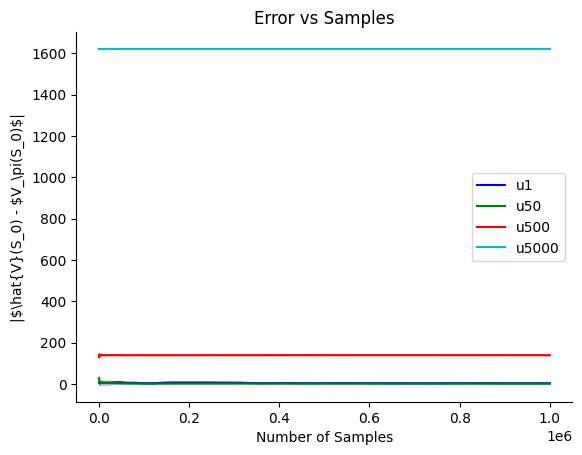

In [224]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", "|$\hat{V}(S_0) - $V_\pi(S_0)$|",
    title="Error vs Samples", show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

# ax.set_xlim(-100, 2000)
# ax.set_yscale('log')
plt.show()

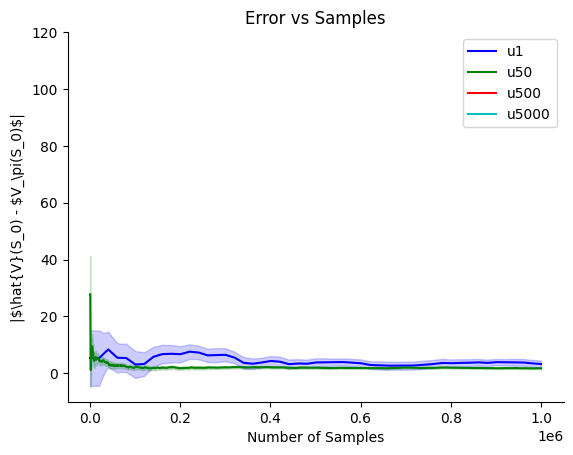

In [225]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", "|$\hat{V}(S_0) - $V_\pi(S_0)$|",
    title="Error vs Samples", show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_ylim(-10, 120)
# ax.set_yscale('log')
plt.show()

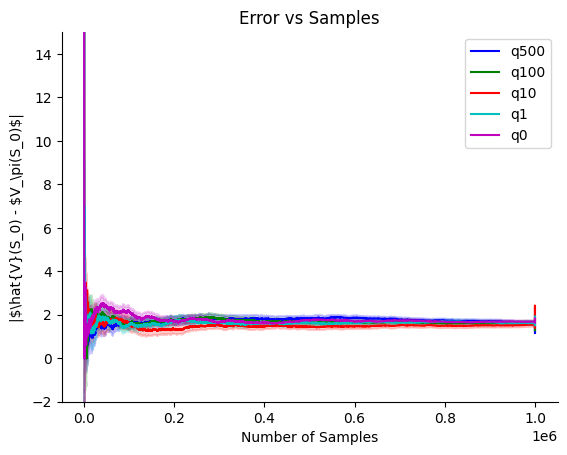

In [226]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", "|$\hat{V}(S_0) - $V_\pi(S_0)$|",
    title="Error vs Samples", show=False, key_filter=lambda x: "q" in x,
    add_stderr=True)

ax.set_ylim(-2, 15)
# ax.set_yscale('log')
plt.show()

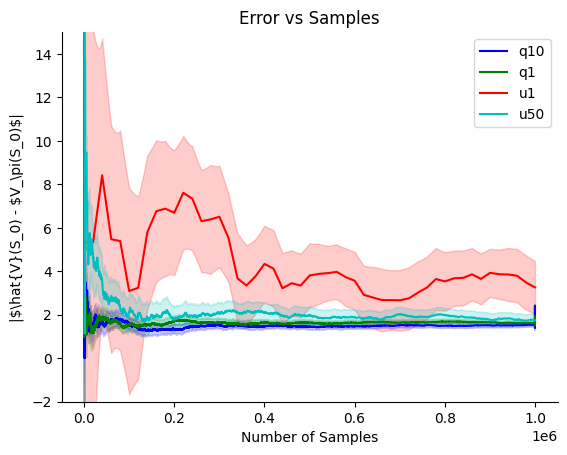

In [227]:
good = ["u1", "u50", "q1", "q10"]

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", "|$\hat{V}(S_0) - $V_\pi(S_0)$|",
    title="Error vs Samples", show=False, key_filter=lambda x: x in good,
    add_stderr=True)

ax.set_ylim(-2, 15)
# ax.set_yscale('log')
plt.show()

# Testing Random Things

In [228]:
(math.pi + 3.5) % (2*math.pi) - math.pi

-2.7831853071795862